In [65]:
import dask.array as da

multiscale = "2"
DATASET_PATH = f"/data/smartspim_zarr_test/Ex_488_Em_525/429940_372540.zarr/{multiscale}"
lazy_data = da.from_zarr(DATASET_PATH)[0, 0, ...]
lazy_data

dask.array<getitem, shape=(1077, 400, 500), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from basicpy import BaSiC

In [8]:
from typing import List, Optional

def flatfield_correction(
    image_tiles: List[np.array],
    flatfield: np.array,
    darkfield: np.array,
    baseline: Optional[np.array] = None,
) -> np.array:
    """
    Corrects smartspim shadows in the tiles generated
    at the SmartSPIM light-sheet microscope.

    Parameters
    ----------
    image_tiles: List[np.array]
        Image tiles that will be corrected

    flatfield: np.array
        Estimated flatfield

    darkfield: np.array
        Estimated darkfield

    baseline: np.array
        Estimated baseline.
        Default: None

    Returns
    -------
    np.array
        Corrected tiles
    """

    image_tiles = np.array(image_tiles)

    if image_tiles.ndim != flatfield.ndim:
        flatfield = np.expand_dims(flatfield, axis=0)

    if image_tiles.ndim != darkfield.ndim:
        darkfield = np.expand_dims(darkfield, axis=0)

    darkfield = darkfield[: image_tiles.shape[-2], : image_tiles.shape[-1]]

    if darkfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the darkfield. Image shape: {image_tiles.shape} - Darkfield shape: {darkfield.shape}"
        )

    if flatfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the flatfield. Image shape: {image_tiles.shape} - Flatfield shape: {flatfield.shape}"
        )

    if baseline is None:
        baseline = np.zeros((image_tiles.shape[0],))

    baseline_indxs = tuple([slice(None)] + ([np.newaxis] * (image_tiles.ndim - 1)))

    # Subtracting dark field
    negative_darkfield = np.where(image_tiles <= darkfield)
    positive_darkfield = np.where(image_tiles > darkfield)

    # subtracting darkfield
    image_tiles[negative_darkfield] = 0
    image_tiles[positive_darkfield] = (
        image_tiles[positive_darkfield] - darkfield[positive_darkfield]
    )

    # Applying flatfield
    corrected_tiles = image_tiles / flatfield - baseline[baseline_indxs]

    # Converting back to uint16
    corrected_tiles = np.clip(corrected_tiles, 0, 65535).astype("uint16")

    return corrected_tiles

def pick_slices(image_stack, percentage, read_lazy=True):
    """
    Pick slices from a 3D image stack based on a given percentage.
    
    Args:
    - image_stack: 3D numpy array representing the image stack (Z, Y, X).
    - percentage: Percentage of the Z stack to pick (between 0 and 1).
    
    Returns:
    - picked_slices: List of slices picked from the image stack.
    """
    z_dim = image_stack.shape[0]
    num_slices_to_pick = int(np.floor(percentage * z_dim))
    
    if num_slices_to_pick == 0:
        raise ValueError("Percentage too low to pick any slices.")
    
    step_size = z_dim // num_slices_to_pick
    
    slices = list(range(0, z_dim, step_size))
    
    picked_slices = None
    if read_lazy:
        picked_slices = [image_stack[i] for i in slices]
        picked_slices = da.stack(picked_slices)
    
    return picked_slices, slices

def shading_correction(
    slides: List[np.array], shading_parameters: dict, mask: Optional[np.array] = None
):
    """
    Computes shading correction for each of the
    provided tiles for further post-processing.

    Parameters
    ----------
    slides: List[List[ArrayLike]]
        List of tiles per slide used to compute
        the shading fitting.

    shading_parameters: dict
        Parameters to build the basicpy object

    mask: ArrayLike
        Mask with weights for each of the pixels
        that determines the contribution of the fields
        to remove the shadows.

    Returns
    -------
    Tuple[Dict]
        tuple with the flatfield, darkfield and
        baseline results from the shadow fitting
        for further post-processing.
    """
    shading_obj = BaSiC(**shading_parameters)
    shading_results = []
    shading_obj.fit(images=np.array(slides), fitting_weight=mask)
    shading_results = {
        "flatfield": shading_obj.flatfield,
        "darkfield": shading_obj.darkfield,
        "baseline": shading_obj.baseline,
    }

    return shading_results

In [9]:
picked_slices, indices = pick_slices(lazy_data, percentage=0.05)
len(picked_slices)

54

In [10]:
picked_slices[0]

dask.array<getitem, shape=(400, 500), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

In [11]:
%%time

picked_slices_in_memory = da.stack(picked_slices).compute()
picked_slices_in_memory.shape

CPU times: user 729 ms, sys: 536 ms, total: 1.26 s
Wall time: 4.98 s


(54, 400, 500)

In [12]:
# from pathlib import Path
# data_folder = Path("/data/smartspim_zarr_test/Ex_488_Em_525")    

# data_in_memory = []

# for folder in data_folder.glob("*.zarr"):
#     print("reading data from ", folder)
#     lazy_data = da.from_zarr(folder.joinpath("0"))[0, 0, ...]
#     picked_slices, indices = pick_slices(lazy_data, percentage=0.05)
#     data_in_memory.append(da.stack(picked_slices).compute())

In [13]:
# from pathlib import Path
# import dask
# import dask.array as da
# from dask.distributed import Client, LocalCluster

# # Define your data folder
# data_folder = Path("/data/smartspim_zarr_test/Ex_488_Em_525")

# # Function to read and process data
# def process_folder(folder):
#     print("reading data from ", folder)
#     lazy_data = da.from_zarr(folder.joinpath("0"))[0, 0, ...]
#     picked_slices, indices = pick_slices(lazy_data, percentage=0.05)
#     return da.stack(picked_slices)

# # Set up a Dask cluster (optional but recommended for parallel execution)
# cluster = LocalCluster()
# client = Client(cluster)

# # Create delayed tasks for each folder
# lazy_results = []
# for folder in data_folder.glob("*.zarr"):
#     lazy_result = dask.delayed(process_folder)(folder)
#     lazy_results.append(lazy_result)

# # Compute all delayed tasks in parallel
# computed_results = dask.compute(*lazy_results)

# # Close the Dask client and cluster
# client.close()
# cluster.close()

# Now, computed_results will contain the processed data
# data_in_memory = [result.compute() for result in computed_results]

In [14]:
# for d in data_in_memory:
#     print(d.shape)
    
print(picked_slices_in_memory.shape)

(54, 400, 500)


In [15]:
%%time

shading_parameters = {
    "get_darkfield": False,
    "smoothness_flatfield": 1.0,
    "smoothness_darkfield": 20,
    "sort_intensity": True,
    "max_reweight_iterations": 35,
    "resize_mode":"skimage_dask"
}

shading_results = shading_correction(
    slides=picked_slices_in_memory, shading_parameters = shading_parameters
)

# flatfield, basicpy_darkfield, baseline = get_retrospective_flatfield_correction(
#     data_folder=data_folder,
#     flats_dir=metadata_flats_dir,
#     no_cells_config=no_cells_config,
#     cells_config=cells_config,
#     shading_parameters=shading_parameters,
#     logger=logger,
# )


/tmp/ipykernel_2352/821917560.py:135: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)


CPU times: user 10.1 s, sys: 395 ms, total: 10.5 s
Wall time: 5.51 s


In [16]:
darkfield = np.full(picked_slices_in_memory.shape[1:], 200).astype(np.uint8)
shading_results['darkfield'] = darkfield
print(darkfield.shape, darkfield.dtype, picked_slices_in_memory.dtype)

(400, 500) uint8 uint16


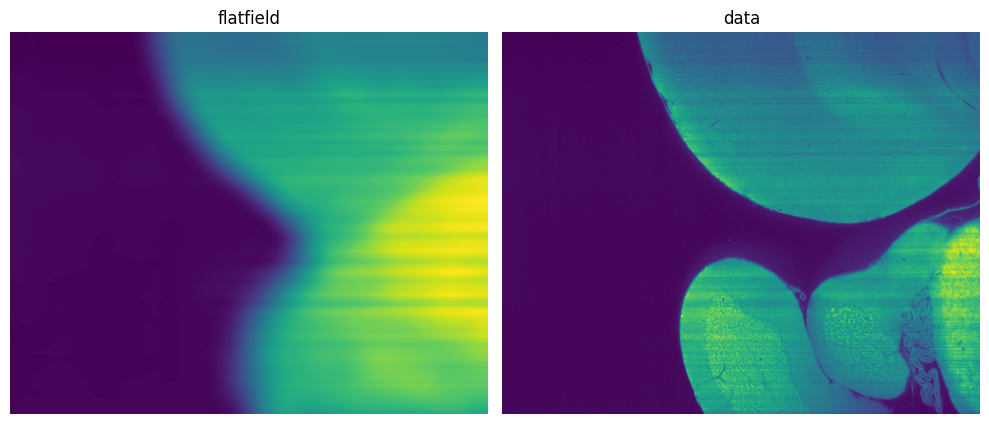

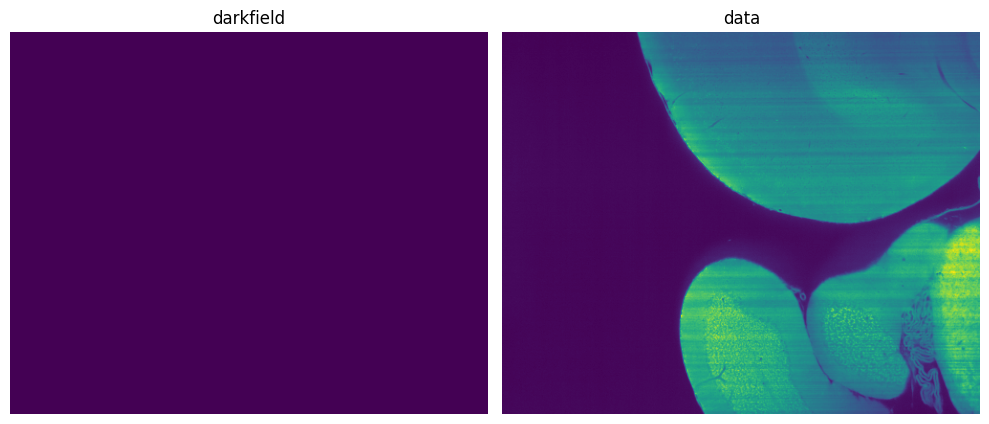

In [17]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(picked_slices_in_memory[
    picked_slices_in_memory.shape[0] // 2,
    ...
])
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# plt.suptitle("darkfield")

# Display images
ax1.set_title('darkfield')
ax1.imshow(shading_results['darkfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(picked_slices_in_memory[
    picked_slices_in_memory.shape[0] // 2,
    ...
])
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

In [18]:

corrected = []
for idx in range(picked_slices_in_memory.shape[0]):
    curr_slide = picked_slices_in_memory[idx]
    
    corrected.append(flatfield_correction(
        image_tiles=curr_slide,
        flatfield=shading_results['flatfield'],
        darkfield=shading_results['darkfield'],
    ))

corrected_slides = np.stack(corrected)

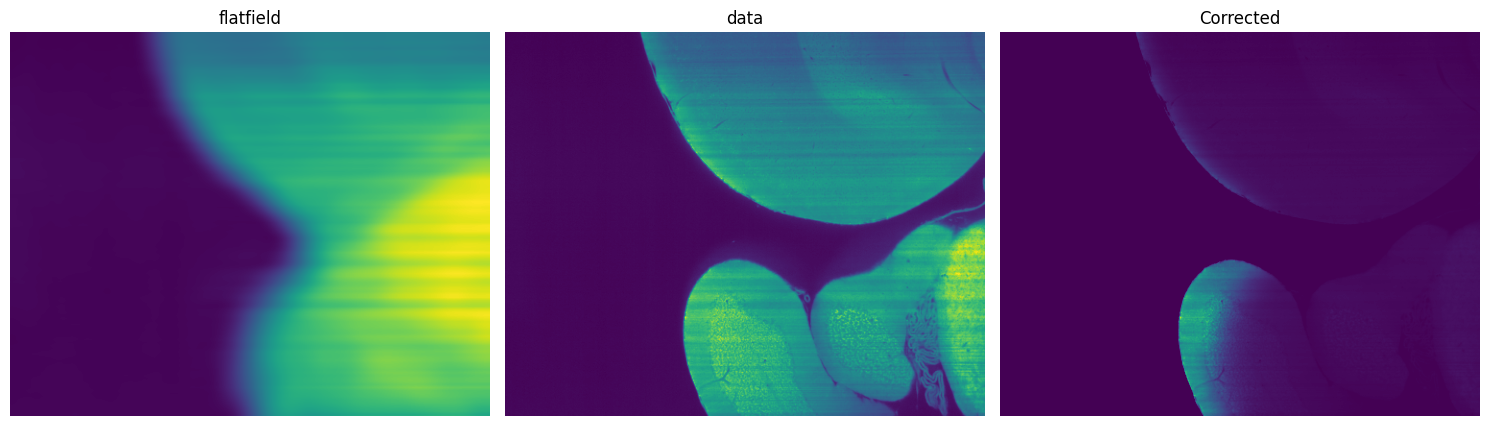

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title("data")
ax2.imshow(picked_slices_in_memory[
    picked_slices_in_memory.shape[0] // 2,
    ...
])
ax2.axis('off')  # Turn off axis labels
ax3.set_title('Corrected')
ax3.imshow(corrected_slides[
    corrected_slides.shape[0] // 2,
    ...
])
ax3.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Computing per slide

Test dir:  /data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525/422310_425580.zarr/2
Z dim:  784 (1, 1, 784, 400, 500)
Len indices: 4 [0, 261, 522, 783]
Plotting
vmin vmax  0.0 7.0


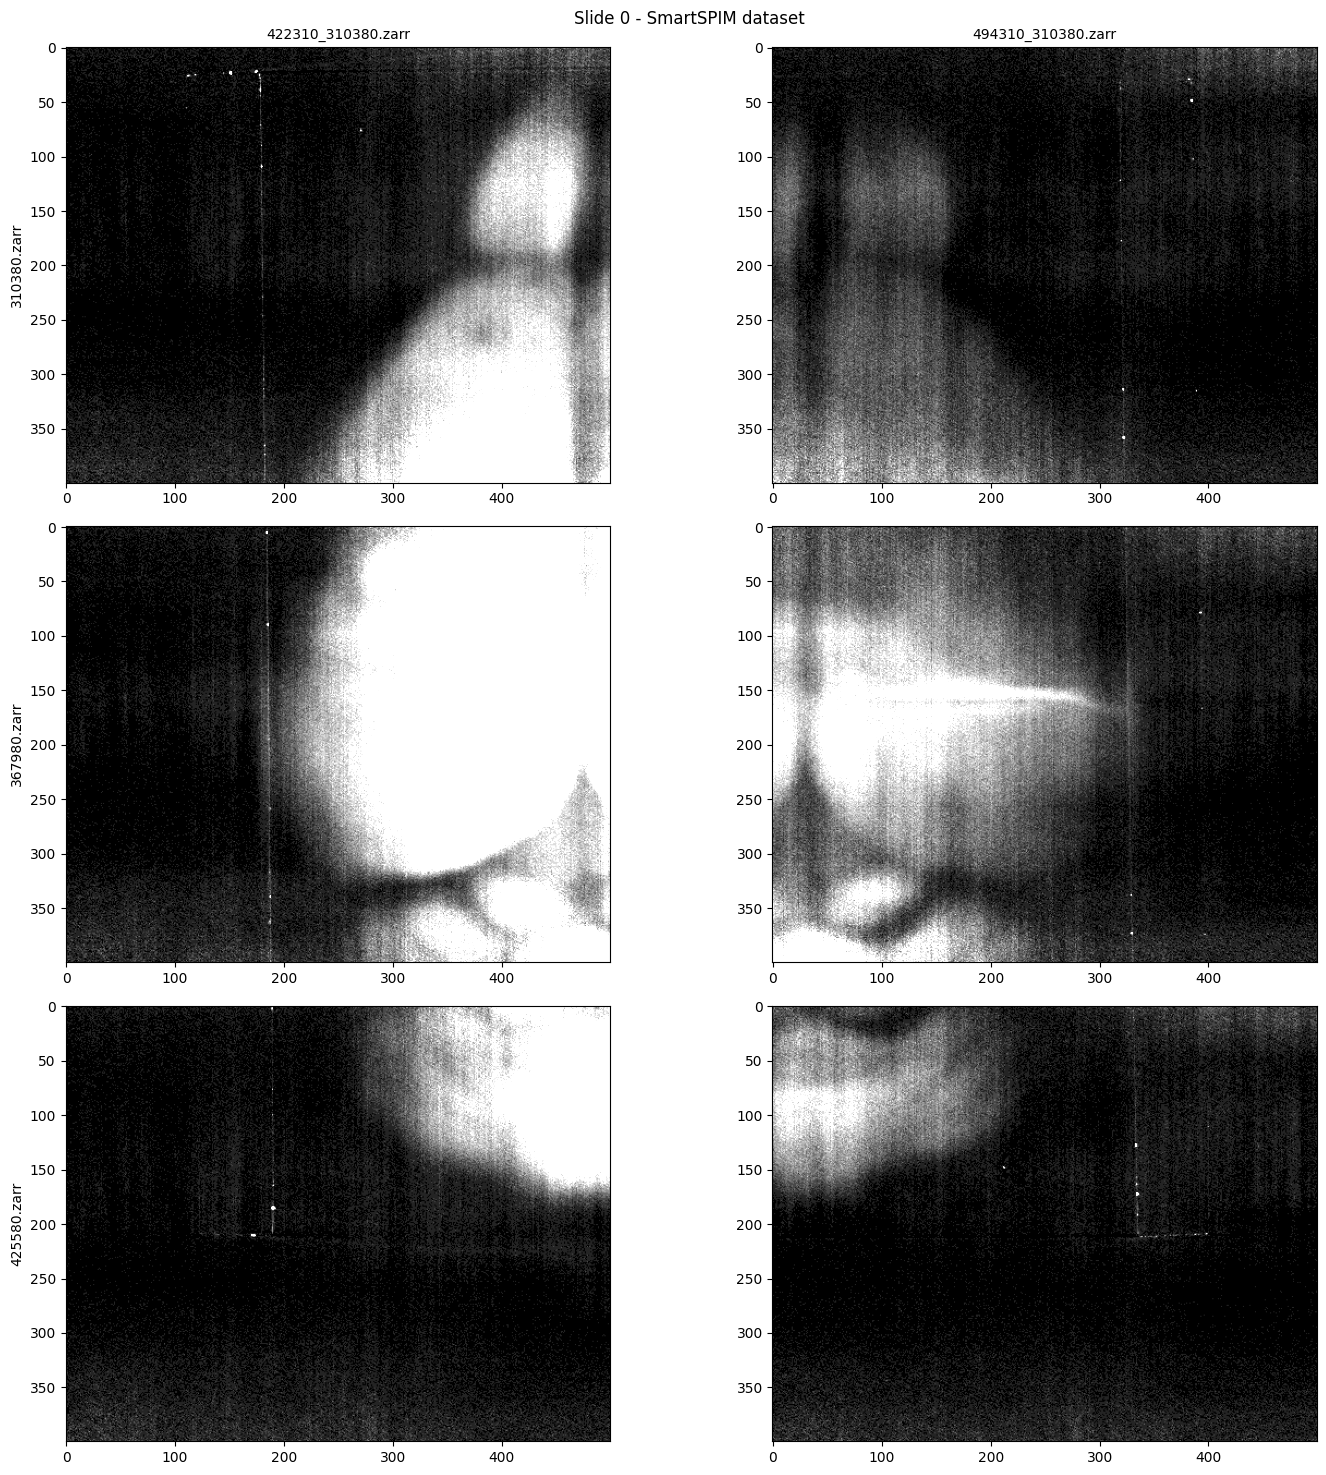

Plotting
vmin vmax  0.0 1191.0010000000184


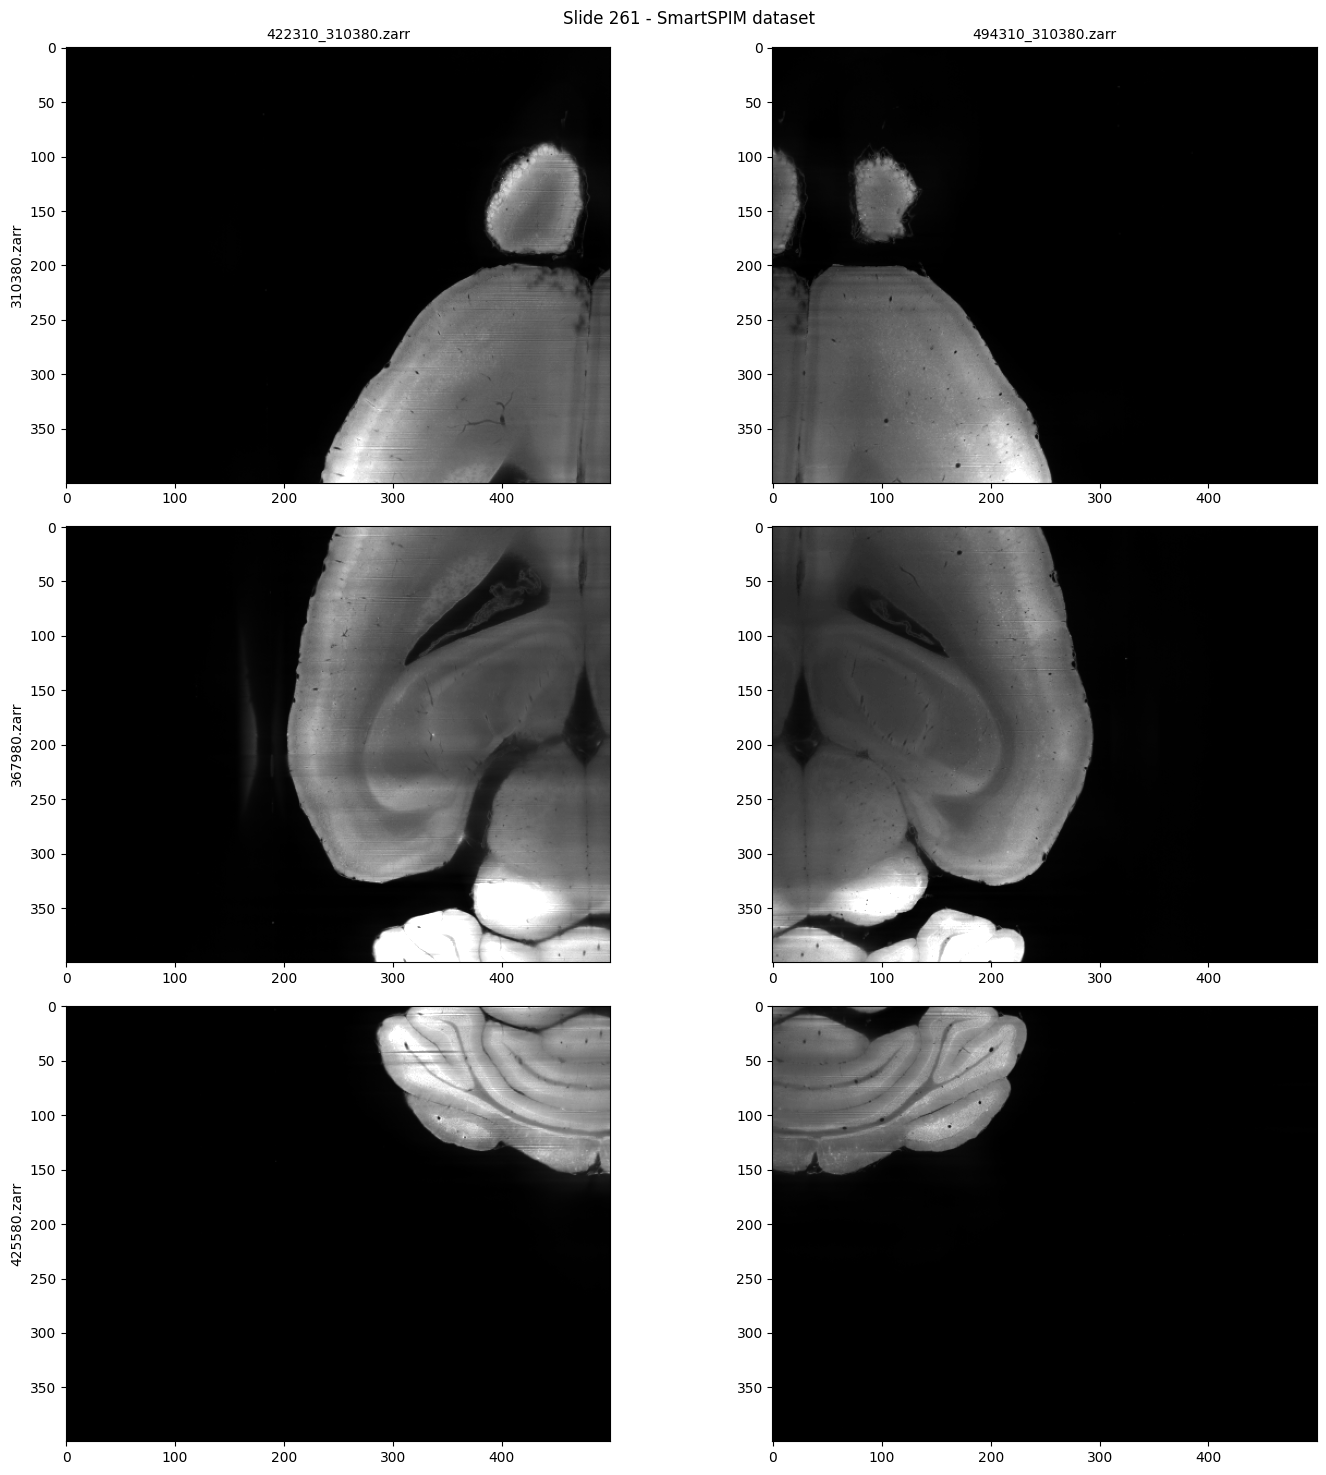

Plotting
vmin vmax  0.0 636.0


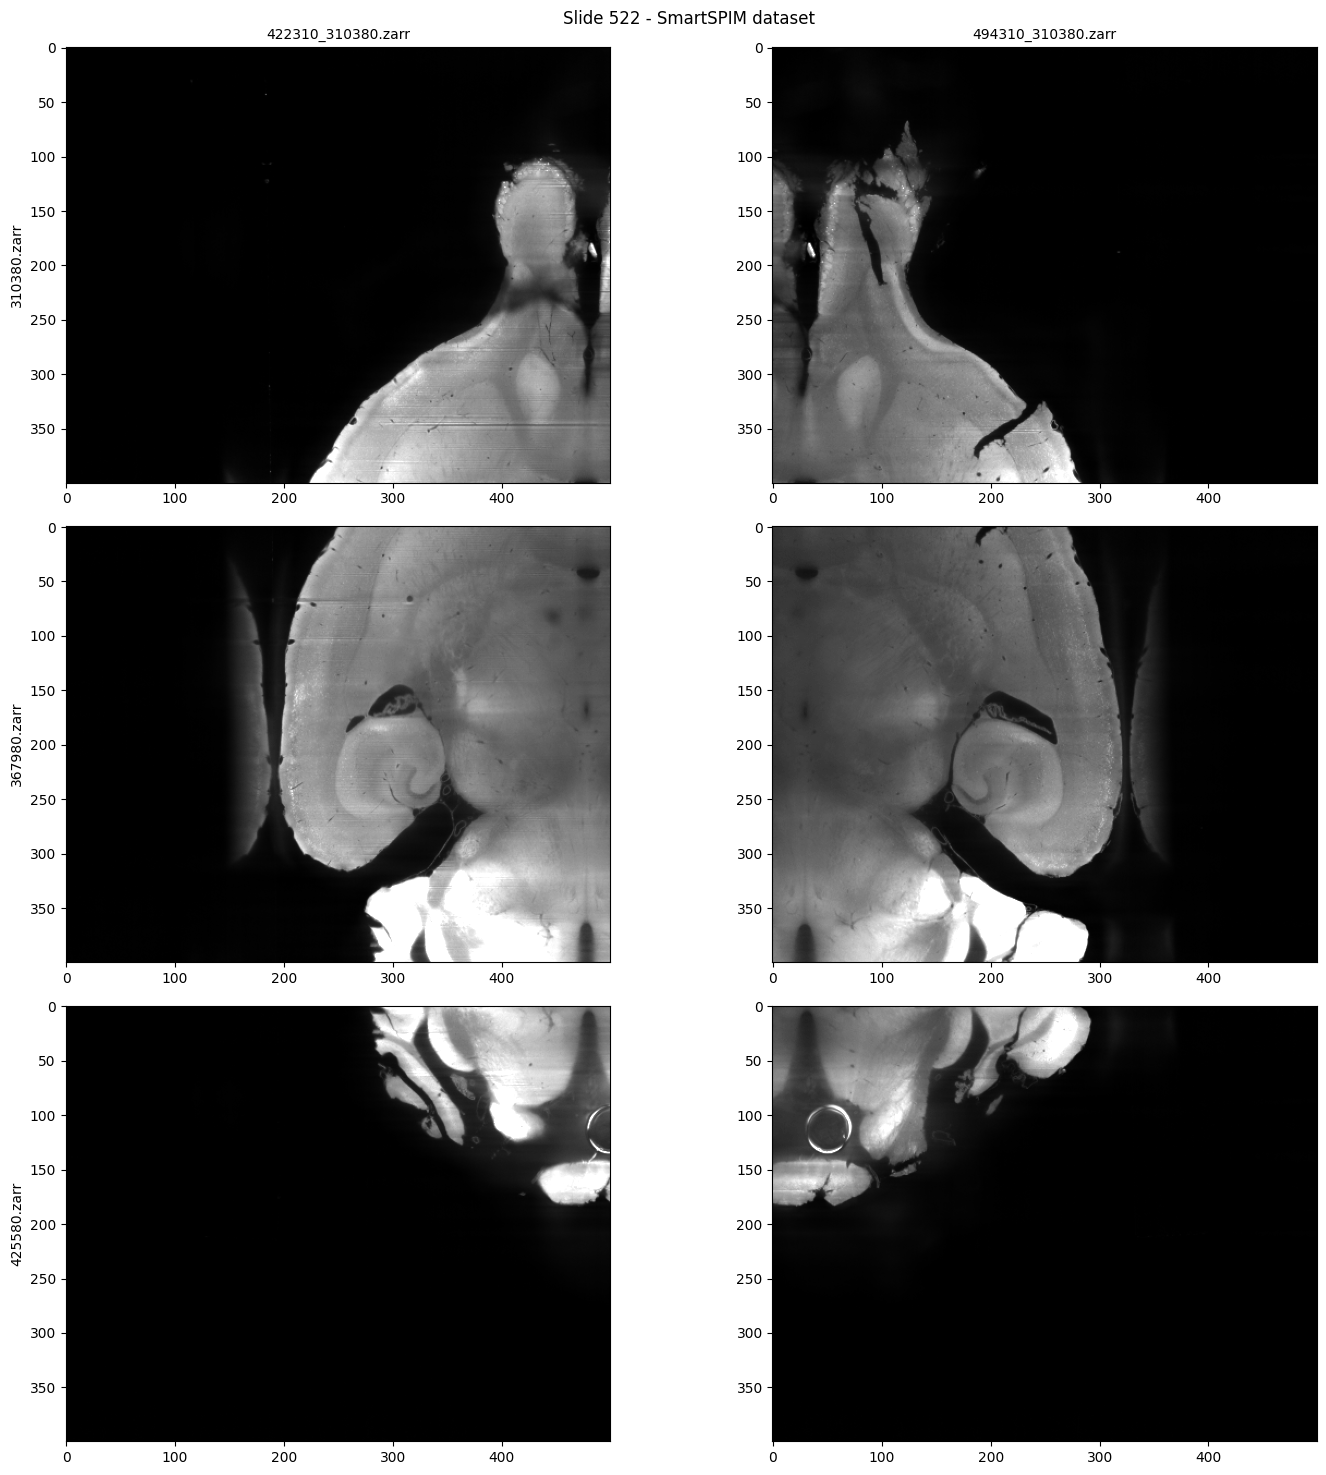

Plotting
vmin vmax  0.0 22.0


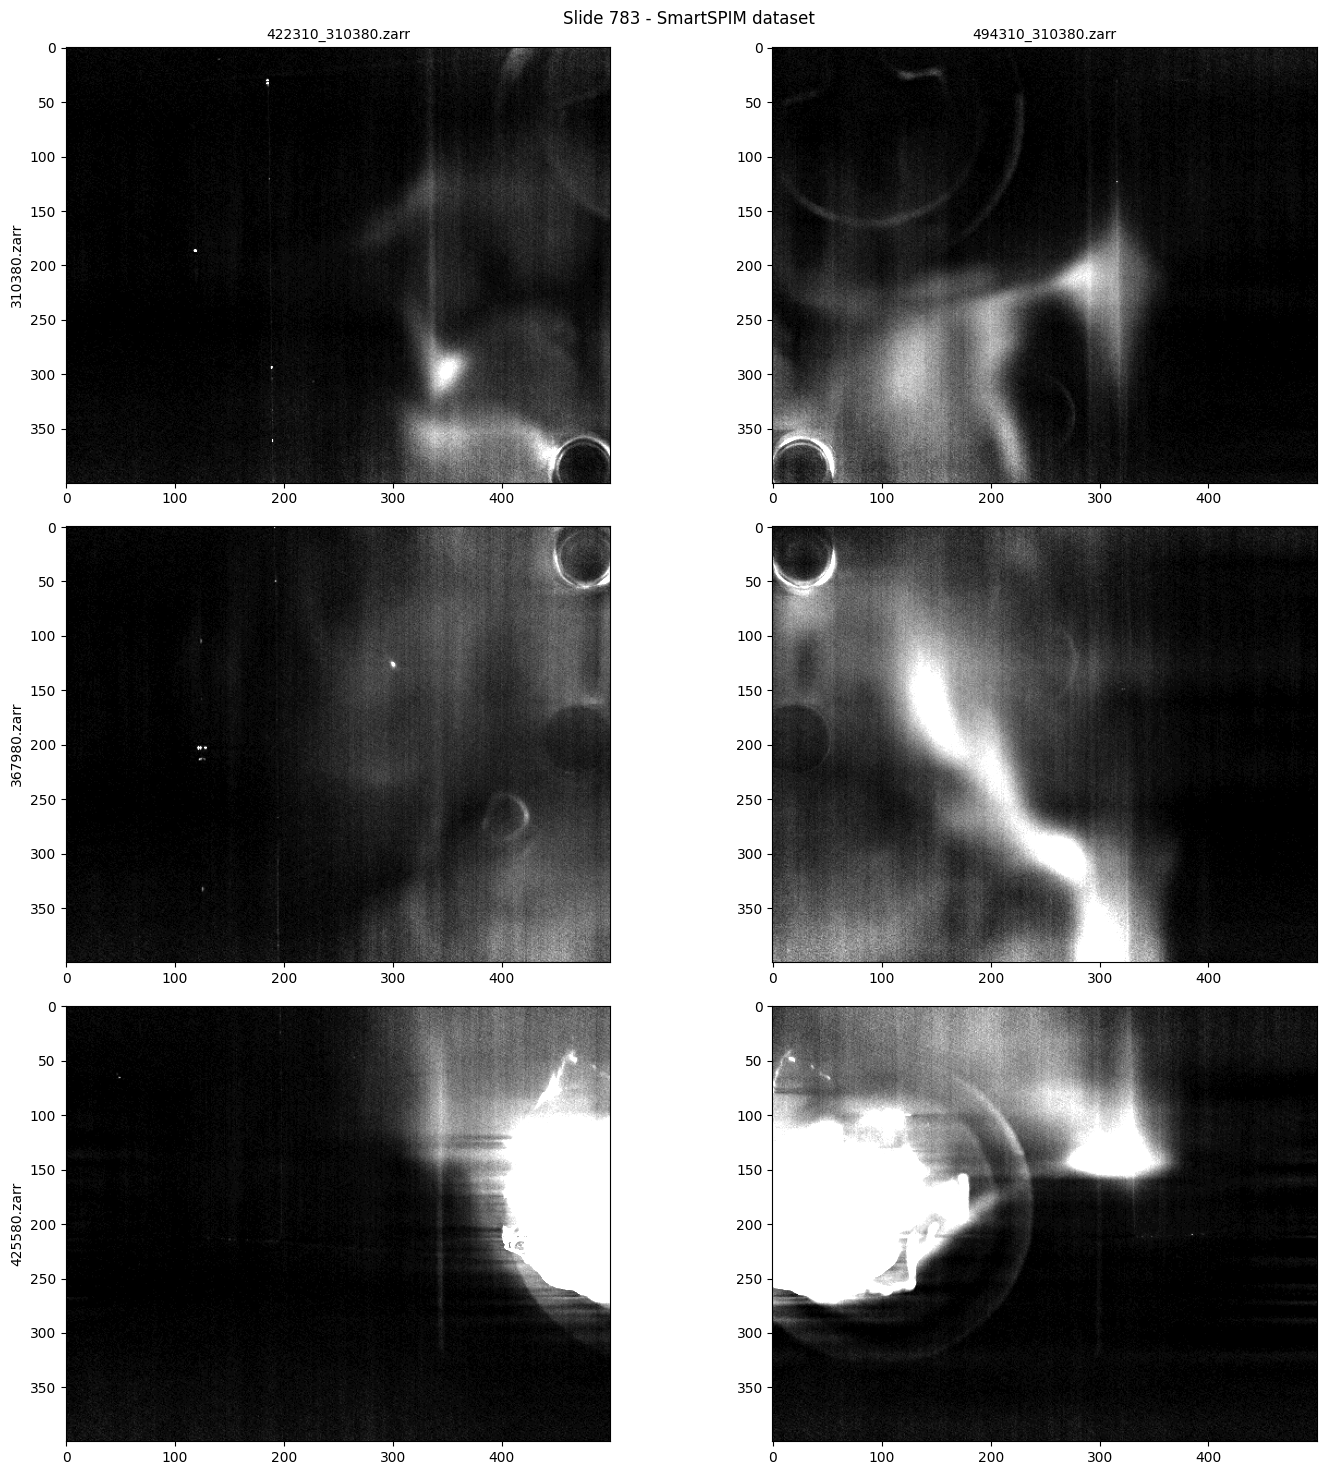

CPU times: user 6.88 s, sys: 815 ms, total: 7.69 s
Wall time: 11.4 s


In [78]:
%%time

from pathlib import Path
from natsort import natsorted
import os
import dask.array as da

from pathlib import Path
from natsort import natsorted

import matplotlib.pyplot as plt
import numpy as np

def show_grid(images:list, names:list, n_rows, n_cols, slide_idx, show_tile_name=False) -> None:
    print("Plotting")
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
    fig.suptitle(f"Slide {slide_idx} - SmartSPIM dataset")
    row_idx = 0
    col_idx = 0
    
    vmin, vmax = np.percentile(images[len(images)//2].flatten(), (0.2, 99.9))   
    print("vmin vmax ",vmin, vmax)

    for img_idx in range(len(images)):
#         print(row_idx, col_idx)
        axs[row_idx][col_idx].imshow(images[img_idx], cmap='gray', vmin=vmin, vmax=vmax)
        
        if show_tile_name:
            #axs[row_idx][col_idx].set_title(names[img_idx], fontsize=8)
            
            if row_idx == 0:
                col = names[img_idx].split("/")[0]
                axs[row_idx][col_idx].set_title(col, fontsize=10)
            
            if col_idx == 0:
                row = names[img_idx].split("_")[-1]
                axs[row_idx][col_idx].set_ylabel(row, fontsize=10)
                
        row_idx += 1

        if row_idx == n_rows:
            row_idx = 0
            col_idx += 1
    
    plt.tight_layout()
    plt.show()

def plot_slide(dataset_path, cols, rows, slide_idx, scale=0, show_tile_name=False):
    
    n_rows = len(rows)
    n_cols = len(cols)
    
    imgs = []
    names = []
    print(f"Getting images from slide {slide_idx}")
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            print(f"Reading {zarr_path}")
            imgs.append(
                da.from_zarr(zarr_path)[0, 0, slide_idx, ...].compute()
#                 img_stack[row_col][slide_idx, :, :]
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    show_grid(imgs, names, n_rows, n_cols, slide_idx, show_tile_name)

def get_brain_slices(dataset_path, cols, rows, slide_idx, scale=0):
    imgs = []
    names = []
    n_rows = len(rows)
    n_cols = len(cols)
    
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            lazy_tile = da.from_zarr(zarr_path)[0, 0, slide_idx, ...]
#             print(f"Worker {os.getpid()} reading {zarr_path} - slide {slide_idx}\n")
            imgs.append(
                lazy_tile.compute()
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    show_grid(imgs, names, n_rows, n_cols, slide_idx, True)
    
    return np.array(imgs), names

def pick_slices(image_stack, percentage, read_lazy=True):
    """
    Pick slices from a 3D image stack based on a given percentage.
    
    Args:
    - image_stack: 3D numpy array representing the image stack (Z, Y, X).
    - percentage: Percentage of the Z stack to pick (between 0 and 1).
    
    Returns:
    - picked_slices: List of slices picked from the image stack.
    """
    z_dim = image_stack.shape[-3]
    print("Z dim: ", z_dim, image_stack.shape)
    num_slices_to_pick = int(np.floor(percentage * z_dim))
    
    if num_slices_to_pick == 0:
        raise ValueError("Percentage too low to pick any slices.")
    
    step_size = z_dim // num_slices_to_pick
    
    slices = list(range(0, z_dim, step_size))
    
    picked_slices = None
    if read_lazy:
        picked_slices = [image_stack[i] for i in slices]
        picked_slices = da.stack(picked_slices)
    
    return picked_slices, slices

data_folder = Path("/data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525")    

scale = 2

test_dir = list(data_folder.glob("*.zarr"))[0].joinpath(str(scale))
print("Test dir: ", test_dir)
lazy_data = da.from_zarr(test_dir)

cols = set()
rows = set()
for folder in data_folder.glob("*.zarr"):
    if folder.suffix == ".zarr":
        col, row = str(folder.stem).split('_')
        cols.add(col)
        rows.add(row)

cols = natsorted(cols)
rows = natsorted(rows)

picked_slices, indices = pick_slices(lazy_data, percentage=0.005, read_lazy=False)
slices = []
names = []

print(f"Len indices: {len(indices)} {indices}")

for indice in indices:
    params = {
        "dataset_path": data_folder,
        "cols": cols,
        "rows": rows,
        "slide_idx": indice,
        "scale": 2
    }
    curr_slcs, curr_nms = get_brain_slices(**params)
    slices.append(curr_slcs)
    names.append(curr_nms)

In [79]:
print(slices[0].shape, names[0])

(6, 400, 500) ['422310_310380.zarr', '422310_367980.zarr', '422310_425580.zarr', '494310_310380.zarr', '494310_367980.zarr', '494310_425580.zarr']


In [80]:
concat_slices = np.concatenate(slices, axis=0)

print(concat_slices.shape)

(24, 400, 500)


In [81]:
shading_parameters = {
    "get_darkfield": False,
    "smoothness_flatfield": 1.0,
    "smoothness_darkfield": 20,
    "sort_intensity": True,
    "max_reweight_iterations": 35,
    "resize_mode":"skimage_dask"
}

shading_results = shading_correction(
    slides=concat_slices, shading_parameters = shading_parameters
)

/tmp/ipykernel_2352/821917560.py:135: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)


In [98]:
# getting median column
med = np.median(shading_results['flatfield'], axis=1)
image_2d = np.tile(med, (400, 1))
image_2d.shape

(400, 400)

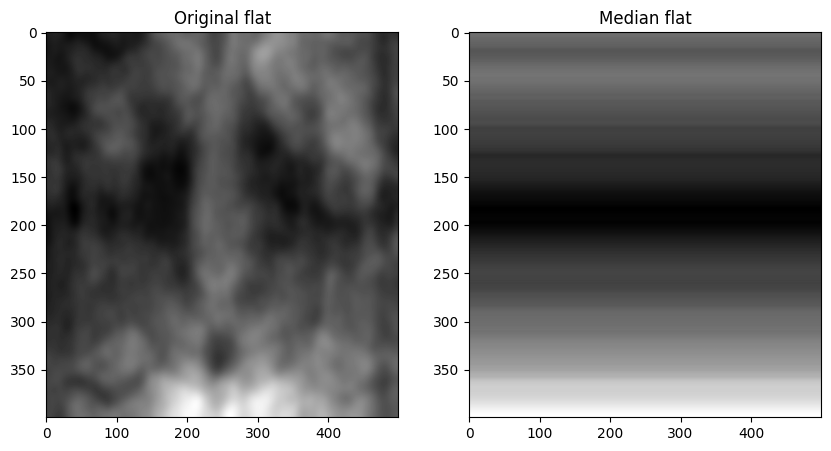

In [106]:
median_row = np.median(shading_results['flatfield'], axis=1)

# Step 2: Create a 2D image from the median row
# Repeat the median row to match the size of the original image
median_image = np.tile(median_row[:, np.newaxis], (1, shading_results['flatfield'].shape[1]))

# Display the original and median images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(shading_results['flatfield'], cmap='gray', aspect='auto')
ax[0].set_title('Original flat')

ax[1].imshow(median_image, cmap='gray', aspect='auto')
ax[1].set_title('Median flat')

plt.show()

(400, 500) uint8 uint16


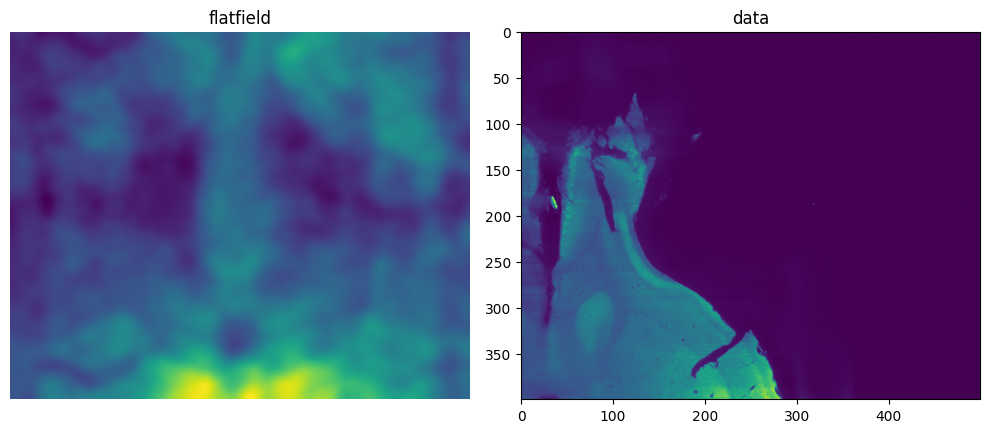

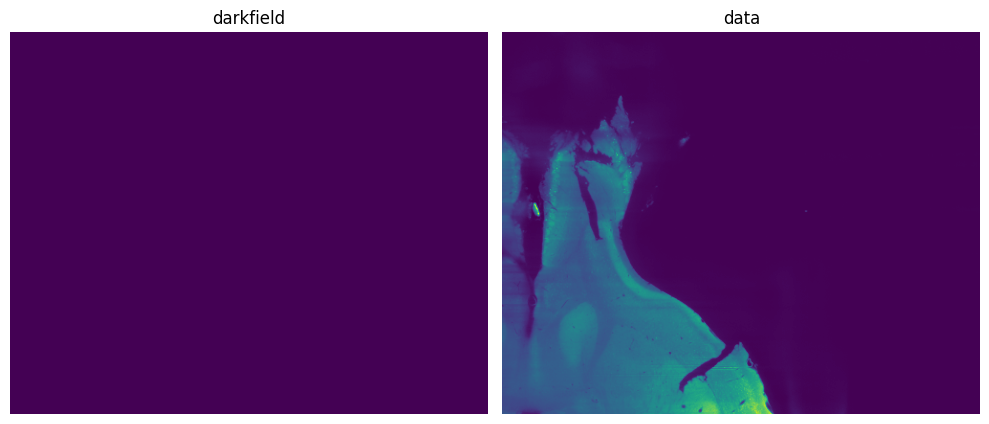

In [86]:
darkfield = np.full(picked_slices_in_memory.shape[1:], 200).astype(np.uint8)
shading_results['darkfield'] = darkfield
print(darkfield.shape, darkfield.dtype, picked_slices_in_memory.dtype)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vis_img = slices[2][3]
# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# plt.suptitle("darkfield")

# Display images
ax1.set_title('darkfield')
ax1.imshow(shading_results['darkfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

(400, 500) uint8 uint16


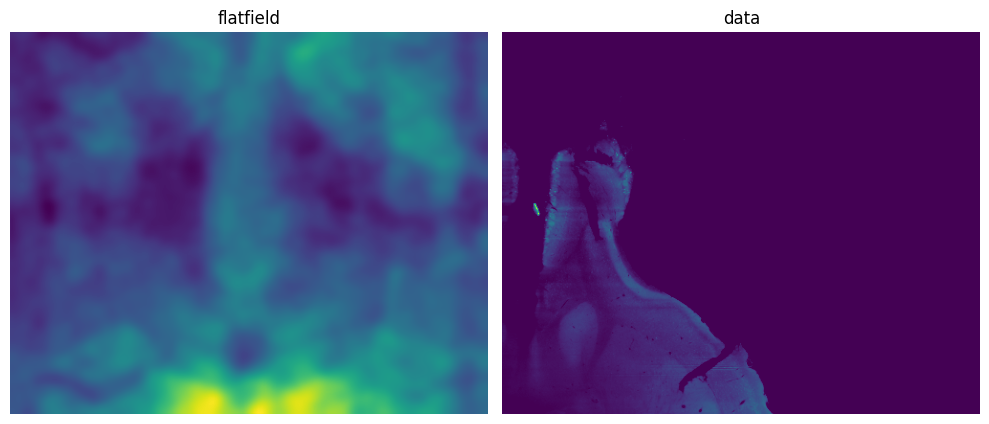

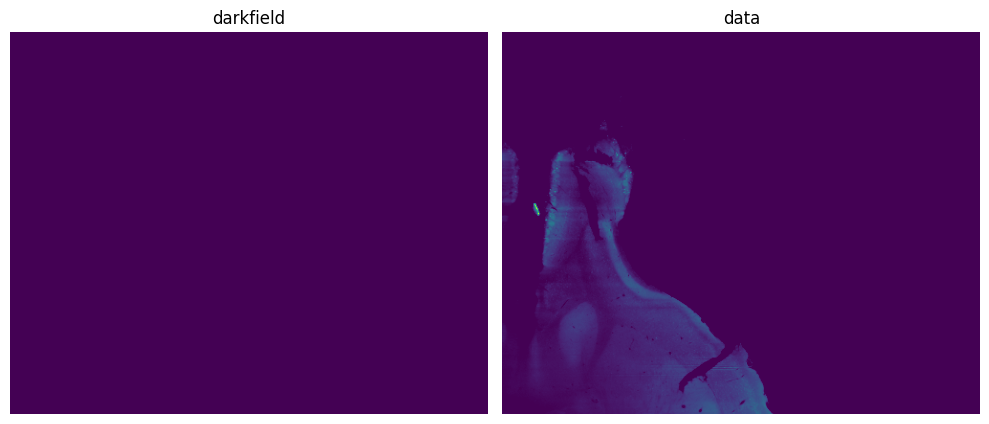

In [107]:
corrected_vis_img = flatfield_correction(
    image_tiles=vis_img,
    flatfield=median_image,#shading_results['flatfield'],
    darkfield=shading_results['darkfield'],
)

darkfield = np.full(corrected_vis_img.shape, 200).astype(np.uint8)
shading_results['darkfield'] = darkfield
print(darkfield.shape, darkfield.dtype, picked_slices_in_memory.dtype)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(corrected_vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# plt.suptitle("darkfield")

# Display images
ax1.set_title('darkfield')
ax1.imshow(shading_results['darkfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(corrected_vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

In [62]:
np.save("/results/corrected_img.npy", corrected_vis_img)
np.save("/results/img.npy", vis_img)